# Netrex+ code debugging and performance testing

In [1]:
#shapes: 
#m = self.NumGene
#l = self.NumExp
#n = self.NumTF

#E=m x l
#S=Cij=lambda_ij=eta_ij=m x n
#A=n x l
#alpha, theta = number
#xi = yj < m,n ...maybe 20,30? 

In [1]:
#needed for package

import numpy as np
import pandas as pd
import sys
import math
import cvxopt
from scipy.linalg import fractional_matrix_power, block_diag
from pylab import *
from cvxpy import *
import argparse
import implicit
from scipy.sparse import csr_matrix
import copy

#testing
from sklearn.metrics import confusion_matrix, precision_score, recall_score

ImportError: No module named 'cvxopt'

In [717]:
class NetREX: 
    #init
    def __init__(self, E, C, lambda_, theta=1, alpha=10, iternum = 1000, p = 30, solver = ECOS):
        #parameters
        self.theta = theta # scalar > 0
        self.alpha = alpha
        self.xbound = 1.0
        self.ybound = 1.0
        self.iternum = iternum
        self.lambda_ = lambda_ #parameter matrix
        #read in exp, read prior data 
        #self.ReadExp(ExpFile) #get ExpMat from this
        self.ExpMat = E #expression for now
        self.C = C #matrix of confidences (weights)
        self.NumGene = E.shape[0]
        self.NumTF = C.shape[1]
        self.NumExp = E.shape[1]
        #parameter matrix eta
        self.eta = self.C + theta
        self.i_ = range(self.NumGene) #range of i
        self.j_ = range(self.NumTF) #range of j 
        #controls amount of factors in xi/yj
        self.p = p
        #set solver
        self.solver = solver
        
    #Put read in exp here later
    
    #initialization
    def initialization(self):
        #!!! other parameters!!!
        #Use implicit package for CF problems to initialize X & Y: 
        implicit_model = implicit.als.AlternatingLeastSquares(factors=self.p)
        #take cutoff of C and add to get new weight matrix
        C_cutoff = np.where(self.C > 0.1, (1 + 5*self.C), 0)
        #train model on weight matrix
        implicit_model.fit(csr_matrix(C_cutoff))
        #initial X (matrix of xi vectors)
        self.X = implicit_model.item_factors.T
        for i in self.i_:
            TmpNorm = np.linalg.norm(self.X[:,i])
            self.X[:,i] = self.X[:,i] / TmpNorm
        np.nan_to_num(self.X, copy=False)
        #initial Y (matrix of yj vectors)
        self.Y = implicit_model.user_factors.T
        for j in self.j_:
            TmpNorm = np.linalg.norm(self.Y[:,j])
            self.Y[:,j] = self.Y[:,j] / TmpNorm
        np.nan_to_num(self.Y, copy=False)
        
        #set initial S to C
        #self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        #S_init = (self.S > 0).astype(int)
        #initialize A using NetREX 1 closed form
        #!!!!!Other options!!!!!
        #Abound = 1.0
        #self.A = np.linalg.inv(S_init.T.dot(S_init)+np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
        #self.A = np.multiply((np.absolute(Atmp)<=Abound), Atmp) + \
                                       # np.multiply((np.absolute(Atmp)>Abound), np.sign(Atmp)*Abound)
        
        #try using NCA to get initial A
        self.A = self.NCA_()
        
        #initial Uk
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        #initial S 
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))  
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(self.S)
        ax2 = plt.subplot(212)
        ax2.imshow(self.X.T.dot(self.Y))
        plt.show() 
    
    #try to program iterative NCA
    def NCA_(self):
        #set initial S to C
        self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        S_init = (self.S > 0).astype(int)
        for k in range(50):
            print(np.linalg.matrix_rank(S_init.T.dot(S_init)), S_init.T.dot(S_init).shape)
            
            A_init = np.linalg.inv(S_init.T.dot(S_init)+ np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
            print(np.linalg.matrix_rank(A_init.dot(A_init.T)), A_init.dot(A_init.T).shape)
            #S_init = self.ExpMat.dot(A_init.T).dot(np.linalg.inv(A_init.dot(A_init.T)) )
        return A_init
        
    #Define the objective function 
    def ObjFunction(self):
        S_0 = (self.S != 0).astype(int) 
        self.a_ = self.lambda_*(self.C + self.alpha*S_0)
        W = np.sqrt(self.a_) 
        Val = np.linalg.norm(self.ExpMat - self.S.dot(self.A), 'fro')**2 +np.linalg.norm(W*(S_0 - self.X.T.dot(self.Y)),
                    'fro')**2 + np.linalg.norm(np.sqrt(self.eta*S_0), 'fro')**2
        return Val
    
    def PALM_A(self):
        mu_A = np.linalg.norm(self.S.T.dot(self.S), 'fro')
        #solution for A
        self.A = (np.linalg.inv((2./mu_A)*self.S.T.dot(self.S)+ np.identity(self.NumTF))).dot(((2./mu_A) * 
                                                                self.ExpMat.T.dot(self.S) + self.A.T).T) 
        
    def PALM_S(self):
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))
        '''
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(c)
        ax2 = plt.subplot(212)
        ax2.imshow(Uk)
        plt.show() 
        
        print(c[30:, 0:20])
        print(Uk[30:, 0:20])
        '''
        
        #solution for S   
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        #print(self.S)
        self.S_0 = (self.S != 0).astype(int)
    
    def solve_qcqp(self, phi, varphi): 
        '''
        Use cvxpy to solve the problem: 
        min x^T*phi*x + varphi*x
        s.t. to norm(x) <= 1
        (problem is the same for y)
        '''
        x = Variable(self.p)
        P = phi.astype(np.double) #this is phi modified for cvxpy
        q = varphi.astype(np.double) #varphi modified for cvxpy
        
        #print(P, q)
        objective = Minimize(quad_form(x,P) - q.T*x)
        constraints = [square(norm(x)) <= 1]
        
        prob = Problem(objective, constraints)
        
        try:
            result = prob.solve(solver=self.solver)
            return x.value
        except:
            prob.solve(verbose=True)
            
            
           
    def PALM_x(self):
        #define variables for matrix formulation
        for i in self.i_: 
            x = self.X[:,i]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_i = np.diag([a_[i,j] for j in self.j_])
            S_i = np.array([S_0[i,j] for j in self.j_]) 
            mu_x = np.linalg.norm(2*self.Y.dot(A_i).dot(self.Y.T), 'fro')                            
            phi = (mu_x/2)*np.identity(self.p) + self.Y.dot(A_i).dot(self.Y.T)
            varphi = 2*S_i.dot(A_i).dot(self.Y.T) + mu_x*x.T 
            self.X[:,i] = self.solve_qcqp(phi, varphi)
        
    def PALM_y(self):
        #matrix formulation
        for j in self.j_:
            y = self.Y[:,j]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_j = np.diag([a_[i,j] for i in self.i_])
            S_j = np.array([S_0[i,j] for i in self.i_])
            mu_y = np.linalg.norm(2*self.X.dot(A_j).dot(self.X.T), 'fro')
            phi = (mu_y/2)*np.identity(self.p) + self.X.dot(A_j).dot(self.X.T)
            varphi = 2*S_j.T.dot(A_j).dot(self.X.T) + mu_y*y.T
            self.Y[:,j] = self.solve_qcqp(phi, varphi)
            
    #algorithm
    def NetREX_algorithm(self):
        self.initialization()
        conv_point = 1 #for now?  

        Valold = self.ObjFunction()
        for k in range(self.iternum): 
            self.PALM_A()
            self.PALM_S()
            self.PALM_x()
            self.PALM_y()
            '''
            plt.figure(1, figsize=(8, 3))
            ax1 = plt.subplot(211)
            ax1.imshow(self.S)
            ax2 = plt.subplot(212)
            ax2.imshow(self.X.T.dot(self.Y))
            plt.show() 
            '''
            Valnew = self.ObjFunction()
            print("Itr %d, Obj %f" % (k, Valnew))
            check_pt = np.abs(Valold-Valnew)
            if (check_pt < conv_point) :
                print("Converge!")
                sys.stdout.flush()
                break
            Valold = Valnew
        return Valold
        
def main():
        #parser = argparse.ArgumentParser(description='netREX: network rewiring using expression')
        #define arguments
        #requiredArgs = parser.add_argument_group('required arguments')
        #requiredArgs.add_argument('-e', type=str, nargs=1, dest='expfile', required=True, metavar="expression_file",
        #                     default=None, help="<Required> Name of the expression file")
        #requiredArgs.add_argument('-c', type=str, nargs=1, dest='confidences', required=True, 
        #                metavar="confidence_matrix", default=None, help='<Required> File w matrix of confidences')
        #parser.add_argument()
    
        #parse arguments from std input
        #args=parser.parse_args()
    
        #if len(sys.argv)==1:
        #    parser.print_help(sys.stderr)
        #    sys.exit(1)
    
        #if args.expfile == None:
        #    sys.exit('missing expression data file!')
        
        #if args.confidences == None:
        #    sys.exit('missing confidence file!')
    
        #run netrex
        #tmp = NetREX(E_real, C_test, lmda_real)
        #tmp.NetREX_algorithm()
        print("Ready")

if __name__ == '__main__':
    main()
    
    
    

Ready


#### Build the simulated dataset for testing. 
This is just to test that the code works. We will use yeast data to test how well the model performs later. 

Simulated dataset should contain: 
- The correct C matrix, as well as the C provided to the model. C needs to have a specific structure, where blocks of varying sizes make up the diagonal. The testing C should have 10% of the values from each nonzero block dropped and replaced by 0s.
- The correct S matrix (1s that correspond to the nonzero elements in C, hence same block structure as C)
- The correct A matrix (made up of random values)
- The correct E matrix (S x A)
- Values for all of the parameters (lambda_, theta, alpha)

In [729]:
#build S with blocks on diagonal

#make 10 blocks of diff sized matrices of 1s
bl1 = np.random.rand(3,2)
bl2 = np.random.rand(3,1)
bl3 = np.random.rand(5,2)
bl4 = np.random.rand(2,2)
bl5 = np.random.rand(3,1)
bl6 = np.random.rand(4,2)
bl7 = np.random.rand(5,2)
bl8 = np.random.rand(2,2)
bl9 = np.random.rand(2,1)
bl10 = np.random.rand(2,1)

S_real = block_diag(bl1, bl2, bl3, bl4, bl5, bl6 , bl7, bl8, bl9, bl10)
S_real_binary = (S_real>0).astype(int)
m = S_real.shape[0] #number genes
n = S_real.shape[1] #number tfs

l = 40 #number exp samples

#build A dim n x l (tf x expsamples)
A_real = np.random.rand(n, l)

#build E dim m x l
E_real = S_real_binary.dot(A_real)
print(E_real.shape, S_real.shape)

(31, 40) (31, 16)


In [730]:
#build weight matrix C dim m x n from S
C_real = copy.deepcopy(S_real)

In [731]:
#build test C 
#make 10% from each of the blocks 0.  
blocks = [bl1, bl2, bl3, bl4, bl5, bl6 , bl7, bl8, bl9, bl10]

for block in blocks: 
    pct = round(block.size * .05)
    for i in range(pct):
        block[np.random.randint(block.shape[0])][np.random.randint(block.shape[1])] = np.random.rand()
    #np.random.permutation(block)
    
dropped_ten_pct = block_diag(bl1, bl2, bl3, bl4, bl5, bl6 , bl7, bl8, bl9, bl10)

#build C with 10% of vals in each block dropped
C_test = dropped_ten_pct * C_real

In [732]:
#build parameter matrix lambda_ dim m x n 
lmda_real = np.ones((m, n))

#set theta and alpha to 1

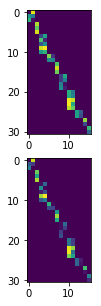

In [733]:
#Visualize S and C
plt.figure(1, figsize=(8, 5))
ax1 = plt.subplot(211)
ax1.imshow(S_real)
ax2 = plt.subplot(212)
ax2.imshow(C_test)
plt.show() 

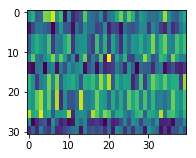

In [734]:
plt.figure(1, figsize=(8, 5))
ax1 = plt.subplot(211)
ax1.imshow(E_real)
plt.show()

In [735]:
np.linalg.matrix_rank(S_test)

15

Use simulated data created above to test the package:

100%|██████████| 15.0/15 [00:00<00:00, 104.98it/s]
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (16, 16)
10 (

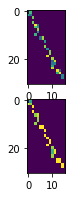

/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/site-packages/cvxpy/atoms/quad_form.py:193: RuntimeWarning: invalid value encountered in true_divide
  w_scaled = w / scale
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/site-packages/cvxpy/atoms/quad_form.py:194: RuntimeWarning: invalid value encountered in greater
  maskp = w_scaled > cond
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/site-packages/cvxpy/atoms/quad_form.py:195: RuntimeWarning: invalid value encountered in less
  maskn = w_scaled < -cond


ValueError: could not broadcast input array from shape (0) into shape (898)

In [724]:
tmp = NetREX(E_real, C_test, lmda_real)
tmp.NetREX_algorithm()

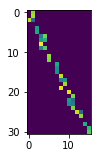

In [678]:
S_test = tmp.S
A_test = tmp.A

plt.figure(1, figsize=(8, 5))
ax1 = plt.subplot(211)
ax1.imshow(tmp.S)
#ax2 = plt.subplot(212)
#ax2.imshow((tmp.S > 0).astype(int))
plt.show()

In [679]:
S_test.shape

(31, 16)

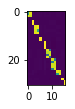

In [680]:
X_test = tmp.X
Y_test = tmp.Y

plt.figure(1, figsize=(8, 3))
ax2 = plt.subplot(212)
ax2.imshow(X_test.T.dot(Y_test))
plt.show()

In [681]:
s_pred = (S_test > 0).astype(int).flatten()
s_real = S_real_binary.flatten()

In [682]:
confmat = confusion_matrix(y_true=s_real, y_pred=s_pred)
print(confmat)

[[444   0]
 [ 16  36]]


In [683]:
print('Precision: %.3f' % precision_score(y_true=s_real, y_pred=s_pred))
print('Recall: %.3f' % recall_score(y_true=s_real, y_pred=s_pred))

Precision: 1.000
Recall: 0.692


### Make the task harder

Have a way to control the sparsity of C, a way to add noise to C and a way to control the noise of E. Then try different combination to see the performance

In [47]:
#drop some percentage of values from C & add some amount of noise
def make_C(C, drop, dist):
    #make some % from each of the blocks false edges.  
    blocks = [bl1, bl2, bl3]
    for block in blocks: 
        pct = round(block.size * drop)
        for i in range(pct):
            block[np.random.randint(block.shape[0])][np.random.randint(block.shape[1])] = np.random.rand()
        np.random.permutation(block)  
    dropped_some_pct = block_diag(bl1, bl2, bl3)

    #C with % of false edges in each block
    C_test = dropped_some_pct * C

    #add noise to off diagonal
    noise = np.where(C == 0, np.random.normal(0, dist, size=(C.shape[0], C.shape[1])), 0)
    C_again = C_test + noise
    return C_again

#add some amount of noise to E
def make_E(E, dist):
    E_new = E + np.random.normal(0, dist, size=(E.shape[0], E.shape[1]))
    return E_new


#NOTE FOR MONDAY: Add noise to area off of the block instead of everything

In [48]:
testC1 = make_C(C_real, 0, .005)
testC2 = make_C(C_real, .15, .005)
testC3 = make_C(C_real, .15, .005)

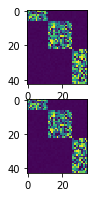

In [49]:
plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(testC1)
ax2 = plt.subplot(212)
ax2.imshow(testC2)
plt.show() 

100%|██████████| 15.0/15 [00:00<00:00, 68.04it/s]


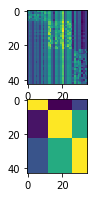

/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in sqrt


Itr 0, Obj nan
Itr 1, Obj nan
Itr 2, Obj nan
Itr 3, Obj nan
Itr 4, Obj nan

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.835e-15  -8.681e+03  +3e+04  4e-01  2e-01  1e+00  5e+03    ---    ---    1  1  - |  -  - 
 1  -3.231e+03  -5.079e+03  +1e+04  2e-01  6e-02  2e+03  2e+03  0.9890  4e-01   2  2  2 |  0  0
 2  -7.731e+02  -9.873e+02  +2e+03  3e-02  7e-03  3e+02  3e+02  0.8421  2e-02   3  3  3 |  0  0
 3  -4.601e+02  -5.056e+02  +2e+02  2e-03  7e-04  2e+00  4e+01  0.9303  7e-02   4  4  4 |  0  0
 4  -4.357e+02  -4.483e+02  +8e+01  6e-04  2e-04  2e+00  2e+01  0.7701  2e-01   4  5  5 |  0  0
 5  -4.364e+02  -4.394e+02  +2e+01  1e-04  5e-05  9e-01  4e+00  0.8735  2e-01   3  4  4 |  0  0
 6  -4.341e+02  -4.350e+02  +7e+00  5e-05  1e-05  3e-01  1e+00  0.8596  2e-01   5  6  6 |  0  0
 7  -4.341e+02  -4.342e+02  +6e-01  4e-06  1e-06  3e-02  1e-01  0.9

DCPError: Problem does not follow DCP rules.

In [50]:
test1 = NetREX(E_real, testC1, lmda_real)
test1.NetREX_algorithm()

In [ ]:
#try again with different solver?

test1_again = NetREX(E_real, testC1, lmda_real, solver=CVXOPT)
test1_again.NetREX_algorithm()

In [ ]:
test2 = NetREX(E_real, testC2, lmda_real)
test2.NetREX_algorithm()

In [ ]:
test3 = NetREX(E_real, testC3, lmda_real)
test3.NetREX_algorithm()

In [ ]:
testE1 = make_E(E_real, .005)

test4 = NetREX(testE1, C_test, lmda_real)
test4.NetREX_algorithm()

In [ ]:
testS4 = test4.S

plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(testS4)
plt.show()

In [ ]:
testE2 = make_E(E_real, .05)

test5 = NetREX(testE2, C_test, lmda_real)
test5.NetREX_algorithm()

In [ ]:
testS5 = test5.S

plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(testS5)
plt.show()

In [ ]:
testC4 = make_C(C_real, 0, .005)

test6 = NetREX(E_real, testC4, lmda_real)
test6.NetREX_algorithm()

In [ ]:
testC5 = make_C(C_real, .15, 0)

test7 = NetREX(E_real, testC5, lmda_real)
test7.NetREX_algorithm()

In [ ]:
testS7 = test7.S

plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(testS7)
plt.show()

#### Test out some other dimensions 

In [ ]:
#build S with blocks on diagonal

#make 3 blocks of diff sized matrices of 1s
bl1 = np.ones((10, 10))
bl2 = np.ones((2, 3))
bl3 = np.ones((15, 30))

S_real = block_diag(bl1, bl2, bl3)
m = S_real.shape[0] #number genes
n = S_real.shape[1] #number tfs

l = 150 #number exp samples

#build A dim n x l (tf x expsamples)
A_real = np.random.rand(n, l)

#build E dim m x l
E_real = S_real.dot(A_real)

#build weight matrix C dim m x n from S
C_real = np.random.rand(m, n) * S_real

#build test C 
#make 10% from each of the blocks 0.  
blocks = [bl1, bl2, bl3]

for block in blocks: 
    pct = round(block.size * .10)
    for i in range(pct):
        block[np.random.randint(block.shape[0])][np.random.randint(block.shape[1])] = 0
    np.random.permutation(block)
    
dropped_ten_pct = block_diag(bl1, bl2, bl3)

#build C with 10% of vals in each block dropped
C_test = dropped_ten_pct * C_real

#build parameter matrix lambda_ dim m x n 
lmda_real = np.ones((m, n))

#set theta and alpha to 1

#Visualize S and C
plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(S_real)
ax2 = plt.subplot(212)
ax2.imshow(C_test)
plt.show() 

In [ ]:
baddim = NetREX(E_real, C_test, lmda_real)
baddim.NetREX_algorithm()

In [ ]:
test_new_C = make_C(C_real, 0, .005)

new_dim_test = NetREX(E_real, test_new_C, lmda_real)
new_dim_test.NetREX_algorithm()

In [ ]:
test_new_C2 = make_C(C_real, .20, 0)

new_dim_test2 = NetREX(E_real, test_new_C2, lmda_real)
new_dim_test2.NetREX_algorithm()

In [ ]:
#Add in later:

#stolen from Netrex 1 code
    def ReadinExp(self, filename):
        df = pd.DataFrame.from_csv(filename, header=None, sep="\t")
        self.Genename = list(df.index)
        #self.ExpMat = np.matrix(df.values)
        TmpExp = np.matrix(copy.deepcopy(df.values))
        RowSumTmpExp = np.sum(TmpExp, axis=1)
        Ind0 = np.where(RowSumTmpExp==0.)[0]
        if(Ind0.size>0):
            sys.exit("Error: Genes %s's Expression has all zeros!!!" % (self.Genename[Ind0[0]]))
        for i in range(TmpExp.shape[1]):
            Range = np.max(TmpExp[:,i]) - np.min(TmpExp[:,i])
            TmpExp[:,i] = (TmpExp[:,i] - np.min(TmpExp[:,i])) / Range
        self.ExpMat = TmpExp
        self.ExpMatFix = np.matrix(copy.deepcopy(TmpExp))
        self.NumGene = df.shape[0] #number of genes
        self.NumExp = df.shape[1]  #number of exp samples